## Hanging out with PYMC

Mark Regan

----

I created this notebook with the objective of learning more about Bayesian statistics & MCMC modeling techniques. I've been hearing great things about a python library called PYMC3 and wanted to get some hands on experience using it.

I will use my Google Hangout data downloaded from [Google Takeout](https://www.google.com/settings/takeout/custom/chat). It contains all chat messages sent or received by me between 2013 and 2016.

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import theano.tensor as tt

from datetime import datetime
from sklearn import preprocessing

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

In [2]:
# Import json data
with open('hangouts.json') as json_file:
    json_data = json.load(json_file)

# Generate map from gaia_id to real name
def user_name_mapping(data):
    user_map = {'gaia_id': ''}
    for state in data['conversation_state']:
        participants = state['conversation_state']['conversation']['participant_data']
        for participant in participants:
            if 'fallback_name' in participant:
                user_map[participant['id']['gaia_id']] = participant['fallback_name']

    return user_map

user_dict = user_name_mapping(json_data)

# Parse data into flat list
def fetch_messages(data):
    messages = []
    for state in data['conversation_state']:
        conversation_state = state['conversation_state']
        conversation = conversation_state['conversation']
        conversation_id = conversation_state['conversation']['id']['id']
        participants = conversation['participant_data']

        all_participants = []
        for participant in participants:
            if 'fallback_name' in participant:
                user = participant['fallback_name']
            else:
                # Scope to call G+ API to get name
                user = participant['id']['gaia_id']
            all_participants.append(user)
            num_participants = len(all_participants)
        
        for event in conversation_state['event']:
            try:
                sender = user_dict[event['sender_id']['gaia_id']]
            except:
                sender = event['sender_id']['gaia_id']
            
            timestamp = datetime.fromtimestamp(long(long(event['timestamp'])/10**6.))
            event_id = event['event_id']

            if 'chat_message' in event:
                content = event['chat_message']['message_content']
                if 'segment' in content:
                    segments = content['segment']

                    for segment in segments:
                        if 'text' in segment:
                            message = segment['text'].strip()
                            message_length = len(message)
                            if len(message) != 0:
                                messages.append((conversation_id,
                                                 event_id, 
                                                 timestamp, 
                                                 sender, 
                                                 message,
                                                 message_length,
                                                 all_participants,
                                                 ', '.join(all_participants),
                                                 num_participants))

    messages.sort(key=lambda x: x[0])
    return messages

# Parse data into data frame
cols = ['conversation_id', 'event_id', 'timestamp', 'sender', 'message', 'message_length', 'participants', 'participants_str', 'num_participants']
messages = pd.DataFrame(fetch_messages(json_data), columns=cols).sort(['conversation_id', 'timestamp'])

# Engineer features
messages['prev_timestamp'] = messages.groupby(['conversation_id'])['timestamp'].shift(1)
messages['prev_sender'] = messages.groupby(['conversation_id'])['sender'].shift(1)
messages = messages[messages['sender'] != messages['prev_sender']]
messages['time_delay_seconds'] = (messages['timestamp'] - messages['prev_timestamp']).astype('timedelta64[s]')
messages = messages[messages['time_delay_seconds'].notnull()]
messages['time_delay_mins'] = np.ceil(messages['time_delay_seconds'].astype(int)/60.0)
messages['day_of_week'] = messages['timestamp'].apply(lambda x: x.dayofweek)
messages['year_month'] = messages['timestamp'].apply(lambda x: x.strftime("%Y-%m"))
messages['is_weekend'] = messages['day_of_week'].isin([5,6]).apply(lambda x: 1 if x == True else 0)

# Limit to messages sent by me
messages = messages[(messages['sender'] == 'Mark Regan') & (messages['participants_str'] != 'Alison Darcy, Mark Regan')]

# Remove messages not responded within 60secs
messages = messages[messages['time_delay_seconds'] < 60]

messages.head(1)

,conversation_id,event_id,timestamp,sender,message,message_length,participants,participants_str,num_participants,prev_timestamp,prev_sender,time_delay_seconds,time_delay_mins,day_of_week,year_month,is_weekend
10,Ugw5Xrm3ZO5mzAfKB7V4AaABAQ,7-H0Z7-FkyB7-HDBYj4KKh,2014-08-15 11:44:12,Mark Regan,Thanks guys!!!,14,"[Keir Alexander, Louise Alexander Regan, Mark ...","Keir Alexander, Louise Alexander Regan, Mark R...",3,2014-08-15 11:44:00,Keir Alexander,12,1,4,2014-08,0


The Hangout data is downloadable in json format. It is heavily nested and contains many attributes. I summarize the key attributes below:

| Field           | Description                                                    | Example                                      |
|-----------------|----------------------------------------------------------------|----------------------------------------------|
| `conversation_id` | Conversation id representing the chat thread                   | Ugw5Xrm3ZO5mzAfKB7V4AaABAQ                   |
| `participants`    | List of participants in the chat thread                        | [Mark, Peter, John]                          |
| `event_id`        | Id representing an event such as chat message or video hangout | 7-H0Z7-FkyB7-H0au2avdw                       |
| `timestamp`       | Timestamp                                                      | 2014-08-15 01:54:12                          |
| `message`         | Content of the message sent                                    | Went to the local wedding photographer today |
| `sender`          | Sender of the message                                          | Mark Regan                                   |

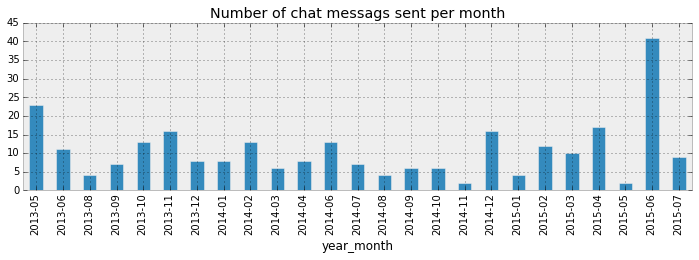

In [3]:
fig = plt.figure(figsize=(12,3))
_ = messages.groupby('year_month').size().plot(kind='bar', title='Number of chat messags sent per month')

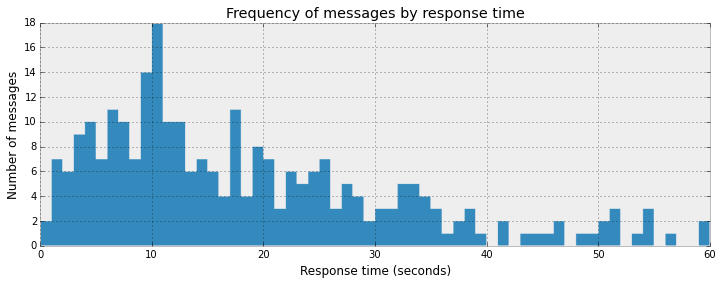

In [5]:
fig = plt.figure(figsize=(12,4))
_ = plt.title('Frequency of messages by response time')
_ = plt.xlabel('Response time (seconds)')
_ = plt.ylabel('Number of messages')
plt.hist(messages['time_delay_seconds'].values, range=[0, 60], bins=60, histtype='stepfilled')
plt.legend(label='', loc='right')

### Estimate response time
The above histogram shows the response time (time between receiving and replying) of messages (j) I sent using Google Hangouts. I would like to estimate parameters for a model that describe my typical response time. Given that this is count data, I think I should model the data as if it were generated by a Poisson distribution. This takes a parameter $\mu$ which represents both the distribution's mean and variance. I will then model $\mu$ as a Gamma distribution with the below priors.

$$y_{j} \sim Poi(\mu)$$
$$\mu = Uniform(0, 100)$$

In [39]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=100)
    y_pred = pm.Poisson('y_pred', mu=mu)
    y_est = pm.Poisson('y_est', mu=mu, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(20000, step, start=start, progressbar=True)

 [-----------------100%-----------------] 20000 of 20000 complete in 2.8 sec

### Posterior distribution of $\mu$
The below frequency plots represents 20,000 samples drawn from the posterior distribution of $\mu$. The plot on the left can be thought of as a histogram of these samples and the plot on the right is called the trace. It captures the sequential sampling of $\mu$ from 0 to 20,000.

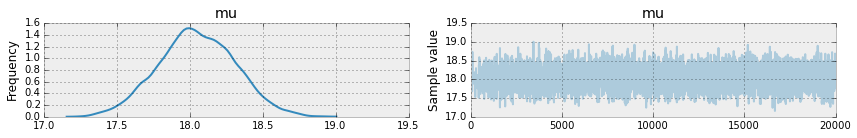

In [40]:
_ = pm.traceplot(trace, vars=['mu'])

### Model convergence: autocorrelation plot
Comment on this

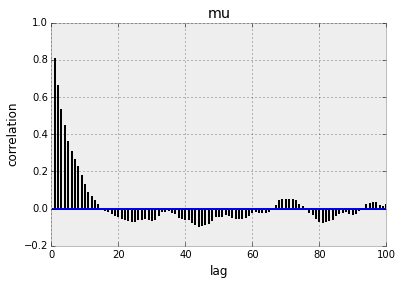

In [41]:
_ = pm.autocorrplot(trace[:2000], vars=['mu'])

### Model checking: Posterior predictive distribution
Just because the model converged does not give any guarentee that the model is an appropriate fit for the underlying data. One method of checking model fit is called the posterior predictive check. This is formally represented as:

$$p(\tilde{y}|y) = \int p(\tilde{y}|\theta) f(\theta|y) d\theta$$

TODO: Add comments on this

PYMC provides a convienant way to sample from the fitted model. You may have noticed a new line in the above model specification: 

`y_pred = pm.Poisson('y_pred', mu=mu)`

This is almost identical to `y_est` except we do not specify the observed data. Pymc considered this to be a stochastic node (as opposed to an observed node). As the MCMC model samples from the posterior distribution of $\mu$, it is computing values for `y_pred`.

We then plot `y_pred` below and compare it to teh observed data `y_est`

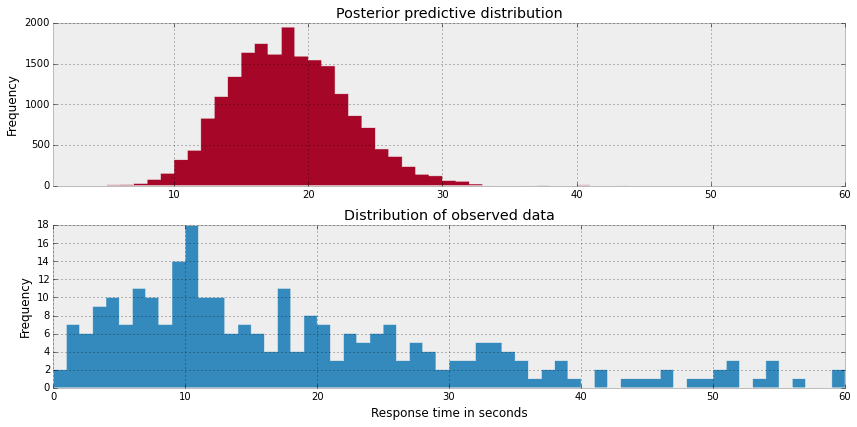

In [43]:
x_lim = 60
y_pred = trace.get_values('y_pred')
mu_mean = trace.get_values('mu').mean()

fig = plt.figure(figsize=(12,6))
fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

### Choosing the right distribution
I'm not particularly happy with the above plot. Ideally, I'd like the posterior predictive distribution to somewhat resemble the distribution of observed data. Clearly we are not seeing that.

One other option we have is the Negative Binomial distribution. This has very similar characteristics to the Poisson distribution except that is has two parameters ($\mu$ and $\alpha$) which enables it to vary its variance independently of its mean. recall that the Poisson has one parameters ($\mu$) that represents both its mean and its variance.

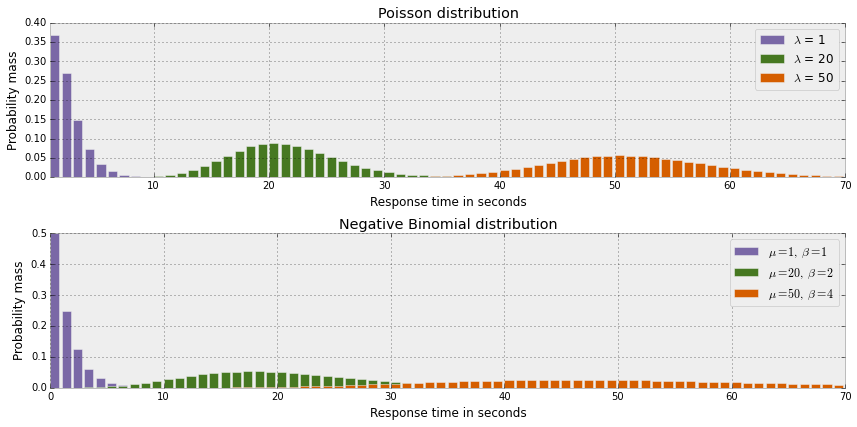

In [44]:
fig = plt.figure(figsize=(12,6))
fig.add_subplot(211)
x_lim = 70
mu = [1, 20, 50]
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu[0], i), color=colors[2])
    plt.bar(i, stats.poisson.pmf(mu[1], i), color=colors[3])
    plt.bar(i, stats.poisson.pmf(mu[2], i), color=colors[4])
    
_ = plt.xlim(1, x_lim)
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Probability mass')
_ = plt.title('Poisson distribution')
_ = plt.legend(['$\lambda$ = %s' % mu[0],
                '$\lambda$ = %s' % mu[1],
                '$\lambda$ = %s' % mu[2]])

# Scipy takes parameters n & p, not mu & alpha
def get_n(mu, alpha):
    return 1. / alpha * mu

def get_p(mu, alpha):
    return get_n(mu, alpha) / (get_n(mu, alpha) + mu)

fig.add_subplot(212)

a = [1, 2, 4]

for i in np.arange(x_lim):
    plt.bar(i, stats.nbinom.pmf(i, n=get_n(mu[0], a[0]), p=get_p(mu[0], a[0])), color=colors[2])
    plt.bar(i, stats.nbinom.pmf(i, n=get_n(mu[1], a[1]), p=get_p(mu[1], a[1])), color=colors[3])
    plt.bar(i, stats.nbinom.pmf(i, n=get_n(mu[2], a[2]), p=get_p(mu[2], a[2])), color=colors[4])

_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Probability mass')
_ = plt.title('Negative Binomial distribution')
_ = plt.legend(['$\\mu = %s, \/ \\beta = %s$' % (mu[0], a[0]),
                '$\\mu = %s, \/ \\beta = %s$' % (mu[1], a[1]),
                '$\\mu = %s, \/ \\beta = %s$' % (mu[2], a[2])])

plt.tight_layout()

Lets go ahead and estimate the parameters for a Negative Binomial data given the same dataset used before. Again, we will use a Uniform distribution to estimate both $\mu$ and $\alpha$. The model can be represented as:

$$y_{j} \sim NegBinomial(\mu, \alpha)$$
$$\mu = Uniform(0, 100)$$
$$\alpha = Uniform(0,100)$$

In [45]:
with pm.Model() as model:
    alpha = pm.Uniform('alpha', lower=0, upper=100)
    mu = pm.Uniform('mu', lower=0, upper=100)
    y_pred = pm.NegativeBinomial('y_pred', mu=mu, alpha=alpha)
    y_est = pm.NegativeBinomial('y_est', mu=mu, alpha=alpha, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(20000, step, start=start, progressbar=True)

 [-----------------100%-----------------] 20000 of 20000 complete in 6.0 sec

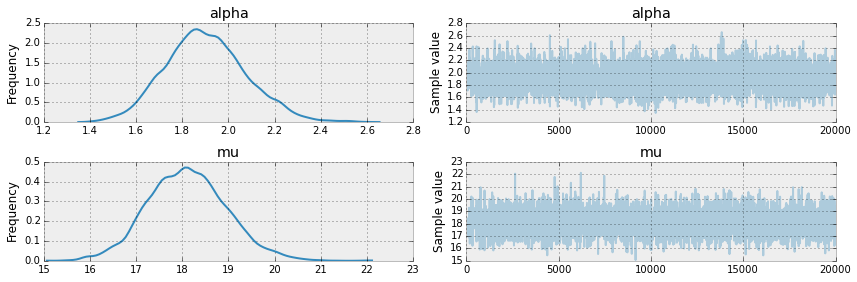

In [46]:
_ = pm.traceplot(trace, vars=['alpha', 'mu'])

We see the above model has greater uncertinity around the estimation of the mean response time $(\mu)$ for chat messages:
- Poisson: 17.5 to 18.5
- Negative Binomial: 16 to 21

Additionally, the Negative Binonomial model has an $\alpha$ parameter of 1.4 to 2.4 which further increases the variance in the estimated parameter `y_est`.

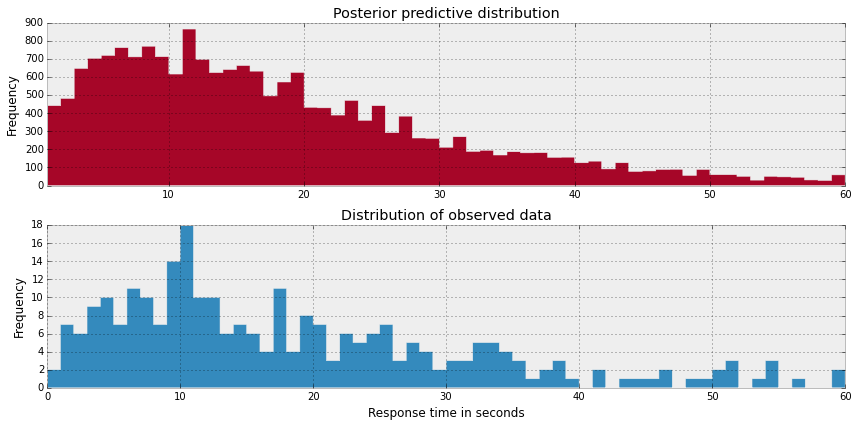

In [47]:
x_lim = 60
y_pred = trace.get_values('y_pred')

fig = plt.figure(figsize=(12,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

The posterior predictive check involves a visual inspection between the observed data and the sampled data from the posterior predictive distribution. We can conclude that the Negative Binomial model is a better fit than the Poisson model.

If you find yourself doubting the rigor of this model checking approach, there are other more analytical methods. 

### Model checking: Bayes Factor
One technique is to compute the Bayes Factor. Add some theory on Bayes Factor here

 [-----------------100%-----------------] 20000 of 20000 complete in 12.5 sec

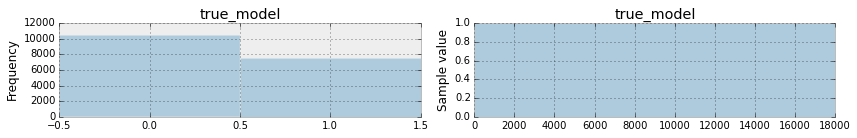

In [48]:
# Compute bayes facor comparing poisson to negbinomial
# Sample code from https://github.com/pymc-devs/pymc3/issues/812

with pm.Model() as model:
    
    # Index to true model
    true_model = pm.DiscreteUniform('true_model', lower=0, upper=1)
    
    # Poisson parameters
    mu_p = pm.Uniform('mu_p', 0, 100)

    # Negative Binomial parameters
    alpha = pm.Uniform('alpha', lower=0, upper=100)
    mu_nb = pm.Uniform('mu_nb', lower=0, upper=100)

    y_like = pm.DensityDist('y_like',
             lambda value: pm.switch(true_model, 
                 pm.Poisson.dist(mu_p).logp(value),
                 pm.NegativeBinomial.dist(mu_nb, alpha).logp(value)
             ),
             observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step1 = pm.Metropolis([mu_p, alpha, mu_nb])
    step2 = pm.ElemwiseCategoricalStep(var=true_model, values=[0,1])
    trace = pm.sample(20000, step=[step1, step2], start=start)

_ = pm.traceplot(trace[2000:], vars=['true_model'])

We can calculate the Bayes Factor for the above two models using the below formulation:

$$Posterior Odds = Bayes Factor * Prior Odds$$

$$\frac{P(M_{1}|D)}{P(M_{2}|D)} = B.F. \times \frac{P(M_{1})}{P(M_{2})}$$

Given that we applied equal prior odds to each model, the Bayes Factor is simple the quotient of the model likelihoods.

In [49]:
# Compute the bayes factor
prob_pois = trace[5000:]['true_model'].mean()
prob_nb = 1 - prob_pois
BF = (prob_nb/prob_pois)
print "Bayes Factor: %s" % BF

Bayes Factor: 1.39463601533


A Bayes Factor of >1 suggests that $M_1$ (Negative Binomial) is more strongly supported by the data than $M_2$ (Poisson). Jeffreys' scale of evidence for Bayes factors interprets a BF of 1.39 as there being weak evidence of $M_1$ over $M_2$ given the data. Combining the posterior predictive check and bayes factor I will conclude that the Negative Binomial is a better model for the given data.

### Model Pooling
Lets explore a different way of modeling the response time for my hangout conversations. My intuition would suggest that depending on the people in a hangout conversation (there can be more than one), my tendancy to reply quickly or slowly will change. As such, I could decide to model each conversation independently, estimating parameters $\mu_i$ and $\alpha_i$ for each conversation $i$.

One consideration we must make, is that some conversations have very few messages compared to others. As such, our estimates of response time for small conversations will have a higher degree of uncertinity than conversations with a large number of messages. The belo plot illustrates the discrepancy in sample size per conversation.

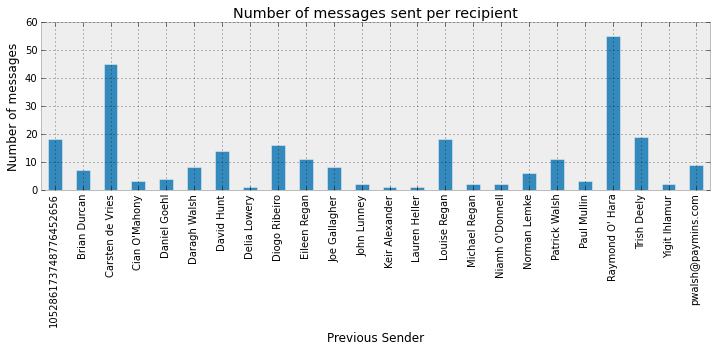

In [133]:
ax = messages.groupby('prev_sender')['conversation_id'].size().plot(
    kind='bar', figsize=(12,3), title='Number of messages sent per recipient')
_ = ax.set_xlabel('Previous Sender')
_ = ax.set_ylabel('Number of messages')

For each message j and each conversation i, we represent the model as:

$$y_{ji} \sim NegBinomial(\mu_i, \alpha_i)$$
$$\mu_i = Uniform(0, 100)$$
$$\alpha_i = Uniform(0, 100)$$

In [131]:
indiv_traces = {}

# Convert categorical variables to integer
le = preprocessing.LabelEncoder()
participants_idx = le.fit_transform(messages['prev_sender'])
participants = le.classes_
n_participants = len(participants)

for p in participants:
    with pm.Model() as model:
        alpha = pm.Uniform('alpha', lower=0, upper=100)
        mu = pm.Uniform('mu', lower=0, upper=100)

        y_est = pm.NegativeBinomial('y_est', 
                                    mu=mu, 
                                    alpha=alpha, 
                                    observed=messages[my_messages['prev_sender']==p]['time_delay_seconds'].values)

        y_pred = pm.NegativeBinomial('y_pred', 
                                     mu=mu, 
                                     alpha=alpha)
        
        start = pm.find_MAP()
        step = pm.Metropolis()
        trace = pm.sample(20000, step, start=start, progressbar=True)
        
        indiv_traces[p] = trace

 [-----------------100%-----------------] 20000 of 20000 complete in 4.8 sec

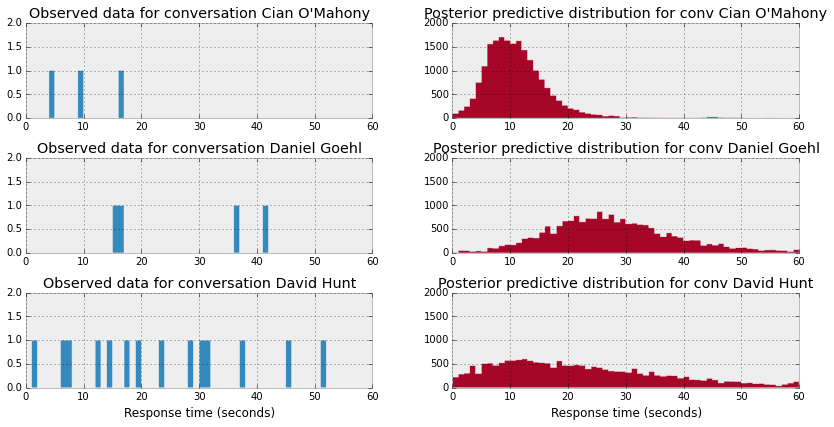

In [146]:
fig, axs = plt.subplots(3,2, figsize=(12, 6))
axs = axs.ravel()
y_left_max = 2
y_right_max = 2000
ix = [3,4,6]

for i, j, p in zip([0,1,2], [0,2,4], participants[ix]):
    axs[j].set_title('Observed: %s' % p)
    axs[j].hist(messages[messages['prev_sender']==p]['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
    axs[j].set_ylim([0, y_left_max])

for i, j, p in zip([0,1,2], [1,3,5], participants[ix]):
    axs[j].set_title('Posterior predictive distribution: %s' % p)
    axs[j].hist(indiv_traces[p].get_values('y_pred'), range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])
    axs[j].set_ylim([0, y_right_max])

axs[4].set_xlabel('Response time (seconds)')
axs[5].set_xlabel('Response time (seconds)')

plt.tight_layout()

The above plots show the observed data (left) and the posterior predictive distribution (right) for 3 example conversations we modeled. As you can see, the posterior predictive distribution can vary considerably across conversations. This could accurately reflect the characteristics of the conversation or it could be a function of sample size.

If we combine the posterior predictive distributions across models, we would expect this to resemble the distribution of the overall dataset observed.

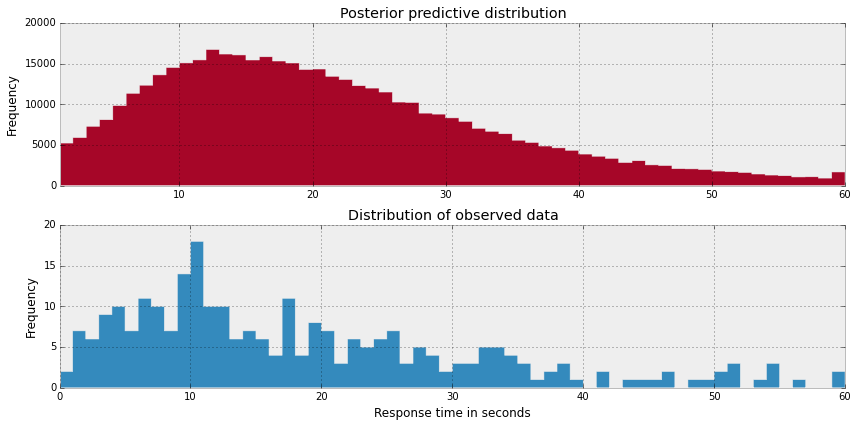

In [148]:
combined_y_pred = np.concatenate([v.get_values('y_pred') for k, v in indiv_traces.iteritems()])

x_lim = 60
y_pred = trace.get_values('y_pred')

fig = plt.figure(figsize=(12,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(combined_y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylim(0, 20000)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlim(0, x_lim)
_ = plt.xlabel('Response time in seconds')
_ = plt.ylim(0, 20)
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

Todo: Need to comment on model fit for the pooled models

### Partial pooling
One of the best aspects of Bayesian modeling is the flexibility of which one can create hierarchal models. Looking at the hangouts data as an example, I believe that I respond faster to some conversations and slower to others. Hence, I feel each conversation warrants its own parameter. However, it intuitively makes sense that I have an overarching tendancy to respond fast or slow to messages regardless of the conversation.

Partial modeling is a great way to model this hierarchal dependancy. I will estimate  parameters $(\mu_j)$ and $(\alpha_j)$ for each conversation j. We represent the model as:

$$y_{ji} \sim NegBinomial(\mu_i, \alpha_i)$$
$$\mu_i = Gamma(HyperMuMu^2/HyperMuDelta^2, HyperMuMu/HyperMuDelta^2)$$
$$\alpha_i = Gamma(HyperAlphaMu^2/HyperAlphaDelta^2, HyperAlphaMu/HyperAlphaDelta^2)$$
$$HyperMuMu = Uniform(0, 60)$$
$$HyperMuDelta = Uniform(0, 50)$$
$$HyperAlphaMu = Uniform(0, 10)$$
$$HyperAlphaDelta = Uniform(0, 50)$$

TODO: Comment on reparamaterization of Gamma. Currently not clear.

In [151]:
with pm.Model() as model:
    hyper_alpha_delta = pm.Uniform('hyper_alpha_delta', lower=0, upper=50)
    hyper_alpha_mu = pm.Uniform('hyper_alpha_mu', lower=0, upper=10)
    
    hyper_mu_delta = pm.Uniform('hyper_mu_delta', lower=0, upper=50)
    hyper_mu_mu = pm.Uniform('hyper_mu_mu', lower=0, upper=60)
    
    alpha = pm.Gamma('alpha', alpha=hyper_alpha_mu**2/hyper_alpha_delta**2, beta=hyper_alpha_mu/hyper_alpha_delta**2, shape=n_participants)
    mu = pm.Gamma('mu', alpha=hyper_mu_mu**2/hyper_mu_delta**2, beta=hyper_mu_mu/hyper_mu_delta**2, shape=n_participants)
    
    y_est = pm.NegativeBinomial('y_est', 
                                mu=mu[participants_idx], 
                                alpha=alpha[participants_idx], 
                                observed=messages['time_delay_seconds'].values)
    
    y_pred = pm.NegativeBinomial('y_pred', 
                                 mu=mu[participants_idx], 
                                 alpha=alpha[participants_idx],
                                 shape=messages['prev_sender'].shape)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    hierarchical_trace = pm.sample(200000, step, progressbar=True)

 [-----------------100%-----------------] 200000 of 200000 complete in 205.6 sec

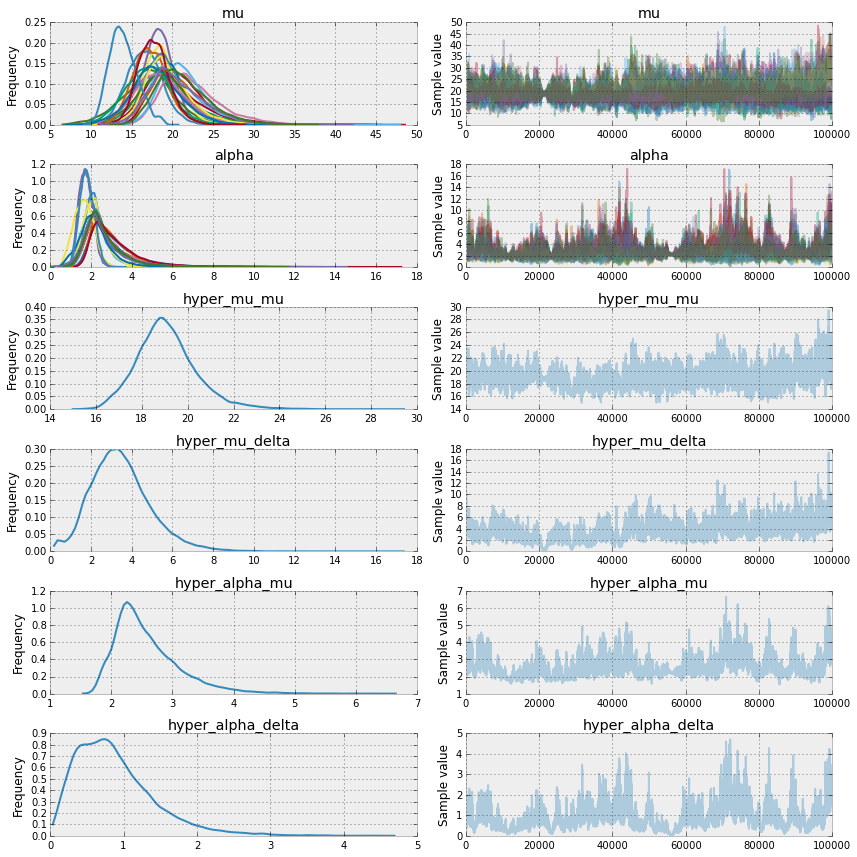

In [152]:
_ = pm.traceplot(hierarchical_trace[100000:], 
                 vars=['mu','alpha','hyper_mu_mu',
                       'hyper_mu_delta','hyper_alpha_mu',
                       'hyper_alpha_delta'])

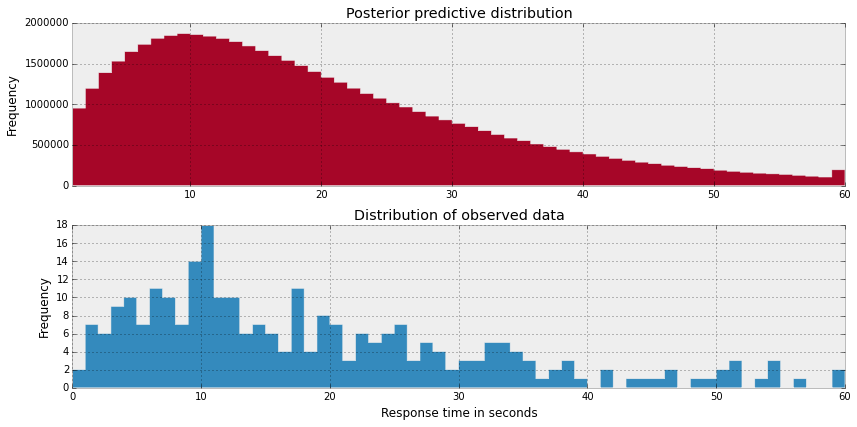

In [153]:
x_lim = 60
y_pred = hierarchical_trace.get_values('y_pred').ravel()

fig = plt.figure(figsize=(12,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(messages['time_delay_seconds'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlabel('Response time in seconds')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

### Shrinkage effect: pooled vs hierarchal model
TODO: Comment on shrinkage effect of hierarchal model

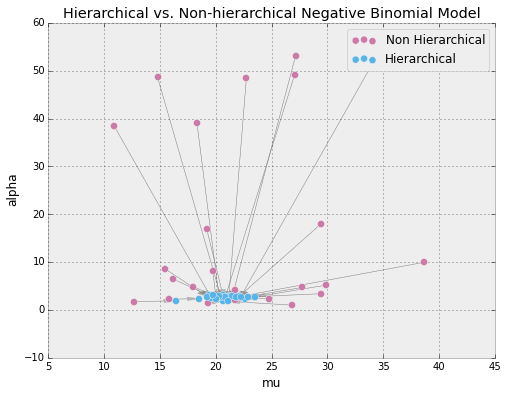

In [154]:
hier_mu = hierarchical_trace['mu'][500:].mean(axis=0)
hier_alpha = hierarchical_trace['alpha'][500:].mean(axis=0)
indv_mu = [indiv_traces[p]['mu'][500:].mean() for p in participants]
indv_alpha = [indiv_traces[p]['alpha'][500:].mean() for p in participants]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, xlabel='mu', ylabel='alpha', 
                     title='Hierarchical vs. Non-hierarchical Negative Binomial Model', 
                     xlim=(5, 45), ylim=(-10, 60))

ax.scatter(indv_mu, indv_alpha, c=colors[5], s=50, label = 'Non Hierarchical', zorder=3)
ax.scatter(hier_mu, hier_alpha, c=colors[6], s=50, label = 'Hierarchical', zorder=4)
for i in range(len(indv_mu)):  
    ax.arrow(indv_mu[i], indv_alpha[i], hier_mu[i] - indv_mu[i], hier_alpha[i] - indv_alpha[i], 
            fc="grey", ec="grey", length_includes_head=True, alpha=.5, head_width=.7)

_ = ax.legend()

### Asking questions to the model
TODO: Make this readable
Questions I might want to ask of the posterior distribution
- what are the chances I will respond to Carsten in less than 20 seconds?
- who are the people I am most likely to respond to fastest?
- need a few good examples here...

In [204]:
def prob_respond(person, response_time):
    # find person's index
    ix = np.where(participants == person)[0][0]
    return 100*np.sum(hierarchical_trace['y_pred'][:, ix] < response_time)/np.float(len(hierarchical_trace['y_pred'][:, ix]))

In [205]:
prob_respond('Daniel Goehl', 33)

82.756

### Poisson Regression
TODO: Fixed effects model

In [ ]:
X = my_messages[['is_weekend','day_of_week','message_length','num_participants']].values
_, num_X = X.shape

# investigate why mu is estimated per row
with pm.Model() as model:
    beta = pm.Normal('beta', mu=0, sd=100, shape=num_X)
        
    mu = pm.Deterministic('mu', var=tt.exp(tt.dot(X, beta)))
    
    #y_pred = pm.Poisson('y_pred', mu=mu)
    y_est = pm.Poisson('y_est', mu=mu, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(20000, step, start=start, progressbar=True)

In [ ]:
_ = pm.traceplot(trace)

In [100]:
_ = pd.scatter_matrix(pm.trace_to_dataframe(trace), figsize=(12,12))
plt.tight_layout()

Exception: Data must be 1-dimensional

Mixed effects model

In [715]:
message_length = messages['message_length'].values

with pm.Model() as model:

    intercept = pm.Normal('intercept', mu=0, sd=100, shape=n_participants)
    slope = pm.Normal('slope', mu=0, sd=100, shape=n_participants)
    
    mu = tt.exp(intercept[participants_idx] + slope[participants_idx]*message_length)
    
    y_pred = pm.Poisson('y_pred', mu=mu, shape=participants_idx.shape)
    y_est = pm.Poisson('y_est', mu=mu, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(20000, step, start=start, progressbar=True)

 [-----------------100%-----------------] 20000 of 20000 complete in 4.8 sec

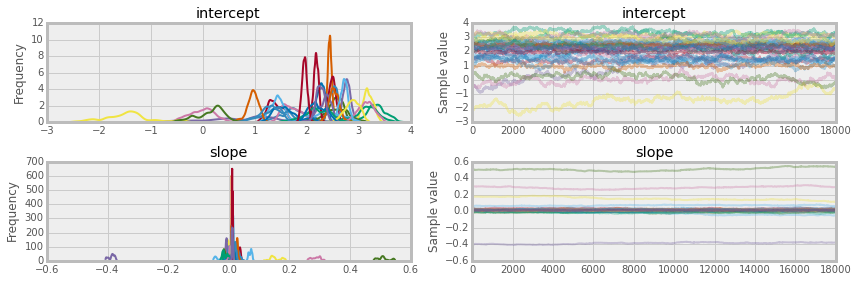

In [716]:
_ = pm.traceplot(trace[2000:])

In [11]:
# Apply pretty styles
from IPython.core.display import HTML

def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()